In [261]:
import pandas as pd
import sqlite3
import numpy as np

In [262]:
conn = sqlite3.connect("../Nexus.db")
#notifications = pd.read_sql_query("SELECT * FROM notifications", conn)
notifications = pd.read_csv("../D_download_stock_price/car.csv", encoding="utf-8")
#stock_prices = pd.read_sql_query("SELECT * FROM stock_prices", conn)
#osbx = pd.read_sql_query("SELECT * FROM osbx", conn)
#insiders_transactions = pd.read_sql_query("SELECT * FROM insider_transactions", conn)
transactions = pd.read_csv("transactions_agg.csv", encoding="utf-8")
conn.close()

In [263]:
notifications.head()

,id,company_name,date,market,issuer_id,link,message,pdf_text,event_date,car_42
0,15939,2020 Bulkers Ltd..json,2019-08-14 13:35:00,XOAX,2020,message_482838,"Olav Eikrem, Chief Technical Officer in 2020 B...",NaN,2019-08-15,0.009525
1,15938,2020 Bulkers Ltd..json,2019-08-21 17:04:00,XOAX,2020,message_483505,"Jeremy Kramer, Director of 2020 Bulkers Ltd., ...",NaN,2019-08-22,0.033167
2,15937,2020 Bulkers Ltd..json,2019-08-22 17:04:00,XOAX,2020,message_483636,"Jeremy Kramer, Director of 2020 Bulkers Ltd., ...",NaN,2019-08-23,0.026759
3,15936,2020 Bulkers Ltd..json,2019-11-26 13:46:00,XOAX,2020,message_490227,"Vidar Hasund, Chief Financial Officer of 2020 ...",NaN,2019-11-27,-0.050793
4,15935,2020 Bulkers Ltd..json,2019-11-27 17:48:00,XOAX,2020,message_490377,"Jeremy Kramer, Director of 2020 Bulkers Ltd., ...",NaN,2019-11-28,-0.103633


In [264]:
#print((notifications["car_10"] > 0).sum())
#print((notifications["car_20"] > 0).sum())
print((notifications["car_42"] > 0).sum())

4224


In [265]:
targets = notifications[["id", "car_42"]]
df_model = transactions.merge(targets, left_on="notification_id", right_on="id", how="inner")

In [266]:
print(len(df_model))
print((df_model["car_42"] == 0.0000).sum()) # might need to check why so many have 0?, dont have time just droping them...
df_model = df_model[df_model["car_42"] != 0.0]

6786
2967


In [267]:
len(df_model)

3819

In [268]:
df_model = df_model.drop(columns=["id", "notification_id"])
df_model

,salary_related,transaction_type_mapped,percentage_change_in_holding,volume,n_people,car_42
12,0,Disposal/Sale of Shares,0.000000,3.163161e+07,2,-0.120709
135,0,Acquisition/Purchase of Shares,0.152886,1.029170e+05,1,-0.014134
136,0,Acquisition/Purchase of Shares,0.000105,8.119445e+04,1,-0.030012
137,0,Acquisition/Purchase of Shares,0.000480,3.841696e+05,1,-0.030012
138,0,Acquisition/Purchase of Shares,0.000669,5.356700e+05,1,-0.030012
...,...,...,...,...,...,...
6738,0,Acquisition/Purchase of Shares,1.000000,1.059584e+05,1,NaN
6771,0,Acquisition/Purchase of Shares,1.000000,8.024000e+04,1,-0.196316
6772,0,Acquisition/Purchase of Shares,0.111890,3.999748e+06,1,-0.273016
6773,0,Acquisition/Purchase of Shares,0.125986,3.999748e+06,1,-0.277037


In [269]:
df_model["car_3class"] = np.select(
    [
        df_model["car_42"] < -0.0,   # Class 0
        #df_model["car_42"].between(-0.02, 0.02),  # Originaly beffor droping 0 values ...
        df_model["car_42"] > 0.0,   # Class 1
    ],
    [0, 1]
)

In [270]:
df_model["car_3class"].value_counts()

car_3class
0    2012
1    1807
Name: count, dtype: int64

In [271]:
df_model["salary_related"].value_counts()

salary_related
0    2649
1    1170
Name: count, dtype: int64

In [272]:
df_model["transaction_type_mapped"].value_counts()

transaction_type_mapped
Acquisition/Purchase of Shares           2705
Disposal/Sale of Shares                   637
Group Not Found                           140
Grant/Award of Rights/Instruments         124
Exercise/Settlement leading to Shares      72
Transfer (Internal/Other)                  45
Administrative/Other/No Transaction        39
Lending/Pledging/Agreement                 16
Share Buyback/Repurchase                   14
Acquisition of Rights/Instruments          14
Exercise and Sale (Net Disposal)            4
Disposal of Rights/Instruments              3
Cash Settlement of Rights/Options           2
Transfer (Outflow/Internal)                 2
Transfer (Rights)                           1
Unclassified/Needs Review                   1
Name: count, dtype: int64

In [273]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


X = df_model[[
    "salary_related",
    "transaction_type_mapped",
    "percentage_change_in_holding",
    "volume",
    "n_people"
]]

y = df_model["car_3class"]

# Column lists
categorical = ["transaction_type_mapped"]
numeric = [
    "salary_related",
    "percentage_change_in_holding",
    "volume",
    "n_people"
]

# one-hot encode the category, keeping numeric features as is
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

# RandomForest model
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    min_samples_split=15,
    random_state=42
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [274]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       594
           1       0.57      0.55      0.56       552

    accuracy                           0.59      1146
   macro avg       0.59      0.59      0.59      1146
weighted avg       0.59      0.59      0.59      1146



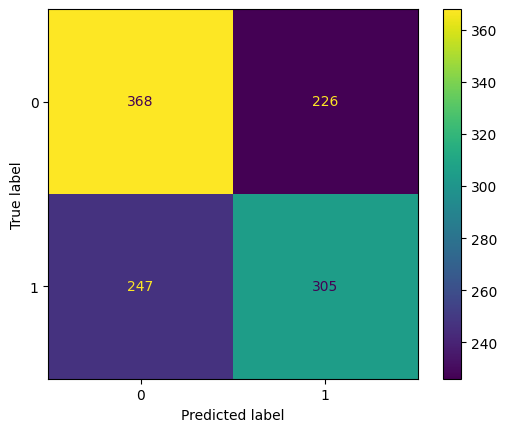

In [275]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
rf = model.named_steps["rf"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]

feature_names = list(ohe.get_feature_names_out(["transaction_type_mapped"])) + [
    "salary_related",
    "percentage_change_in_holding",
    "volume",
    "n_people"
]

fi_df = (
    pd.DataFrame({"feature": feature_names, "importance": rf.feature_importances_})
      .sort_values("importance", ascending=False)
)
fi_df


,feature,importance
18,volume,0.484175
17,percentage_change_in_holding,0.330651
19,n_people,0.097994
16,salary_related,0.022981
1,transaction_type_mapped_Acquisition/Purchase o...,0.011435
5,transaction_type_mapped_Disposal/Sale of Shares,0.009750
7,transaction_type_mapped_Exercise/Settlement le...,0.008894
9,transaction_type_mapped_Group Not Found,0.006616
8,transaction_type_mapped_Grant/Award of Rights/...,0.005116
12,transaction_type_mapped_Transfer (Internal/Other),0.005018


In [277]:
df_model = df_model[(df_model["salary_related"] == 0)]
df_model = df_model[(df_model["transaction_type_mapped"] == "Acquisition/Purchase of Shares")]
df_model = df_model[(df_model["percentage_change_in_holding"] >= 0.5)]
df_model = df_model[(df_model["volume"] >= 950000)]
df_model = df_model[(df_model["n_people"] == 1)]

In [278]:
df_model["car_3class"].value_counts()

car_3class
0    98
1    80
Name: count, dtype: int64